In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa

from src.ssm_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sample_score = converter.parse("data/asap-dataset/Schubert/Impromptu_op.90_D.899/3/xml_score.musicxml") # converter is from the music21 package
# linearized_sample_score = sample_score.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_sample_score = sample_score
# linearized_sample_score.show()

In [4]:
# Cast notes as MIDI note numbers
midi_sequence = []

## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for event in linearized_sample_score.recurse().notes:
    try:
        midi_sequence.append(event.pitch.midi)
    except:
        pass
## END STUDENT SECTION ##


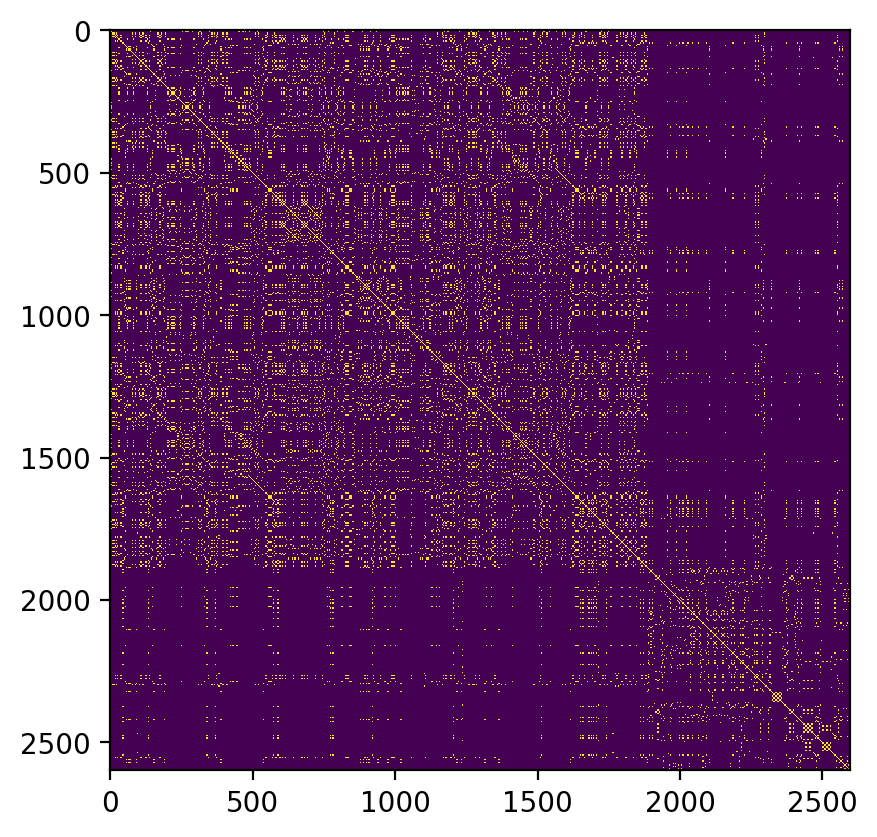

In [5]:

# Kronecker function for upcoming matrix (do not modify)
self_sim_mat1 = calculate_ssm(midi_sequence, kronecker_delta)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat1, cmap='viridis', interpolation='nearest')
# plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
# plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

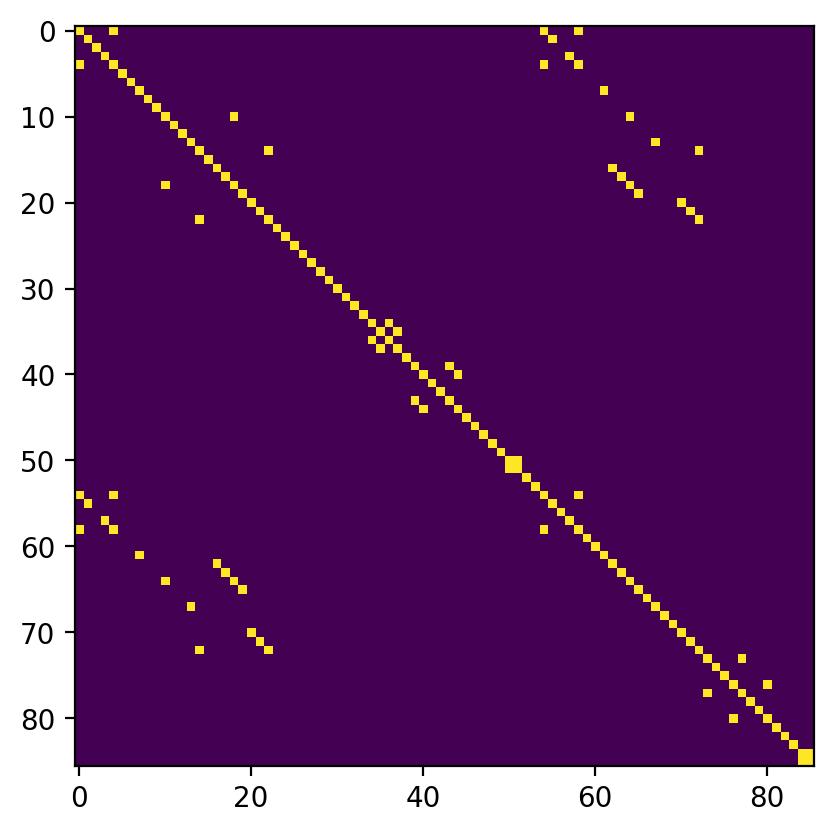

In [6]:
# Cast measures as lists of MIDI note numbers

midi_measure_sequence = []
## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for measure in linearized_sample_score.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        try:
            measure_midi_list.append(event.pitch.midi)
        except:
            pass
    midi_measure_sequence.append(measure_midi_list)
    
# join measures 69/70 and 81/82
m69 = midi_measure_sequence[68] + midi_measure_sequence[69]
m81 = midi_measure_sequence[80] + midi_measure_sequence[81]

midi_measure_sequence[80] = m81
midi_measure_sequence.pop(81)
midi_measure_sequence[68] = m69
midi_measure_sequence.pop(69)

# Create similarity matrix from MIDI measure lists
self_sim_mat2 = calculate_ssm(midi_measure_sequence, kronecker_delta)

plt.imshow(self_sim_mat2, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

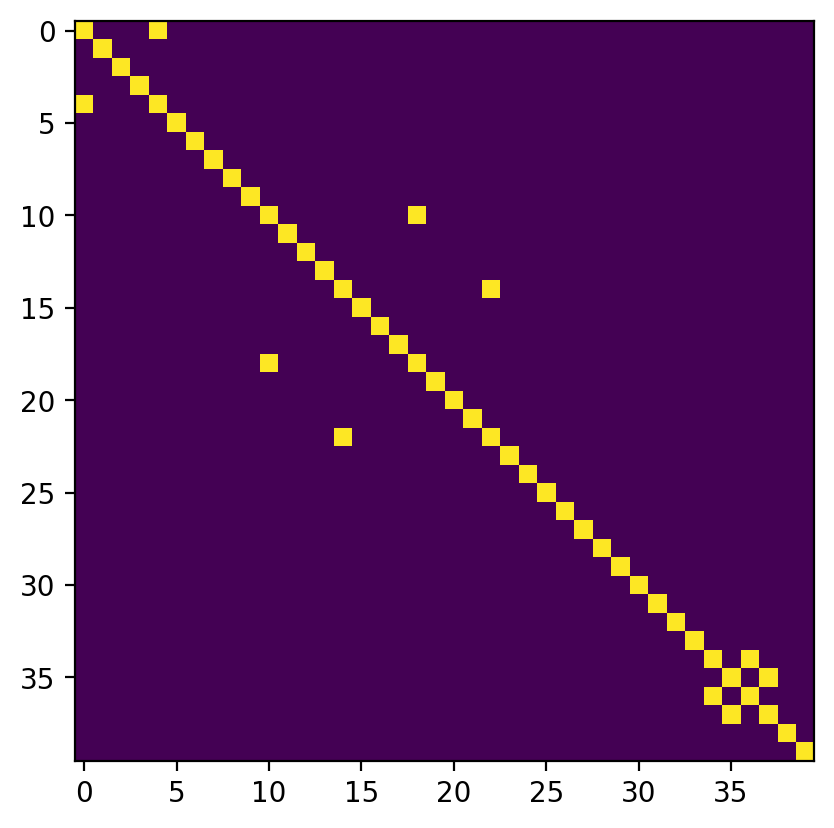

In [7]:
# Slice the matrix to get only the first 40 lines
sliced_self_sim_mat2 = self_sim_mat2[:40,:40]

# Display the sliced matrix
plt.imshow(sliced_self_sim_mat2, cmap='viridis', interpolation='nearest')
plt.show()

/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/f

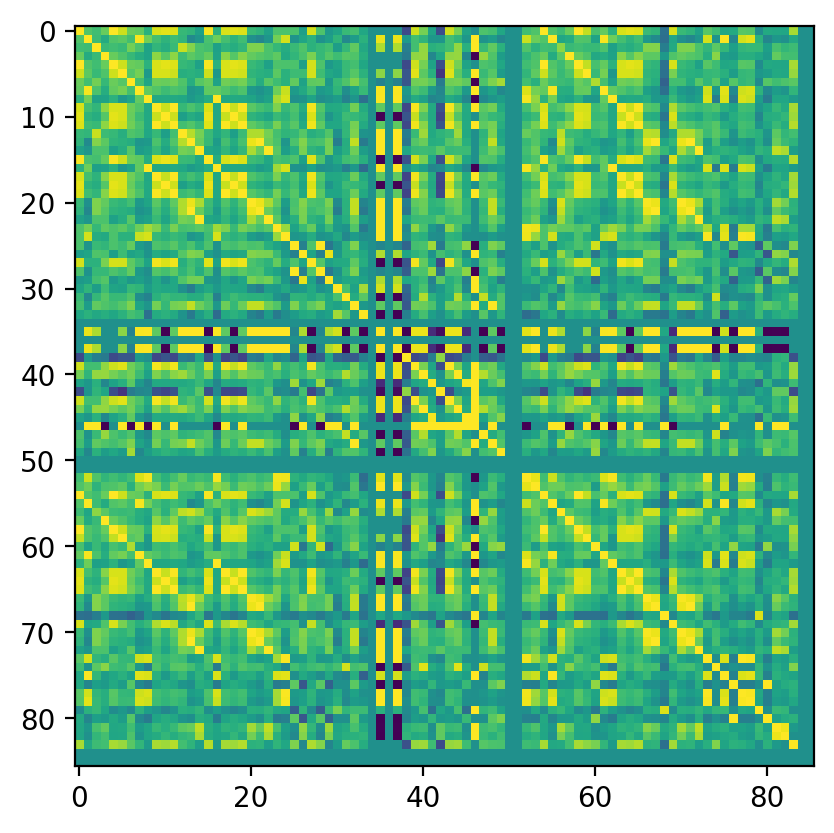

In [8]:
self_sim_mat2 = calculate_ssm(midi_measure_sequence, calculate_correlation)

plt.imshow(self_sim_mat2, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

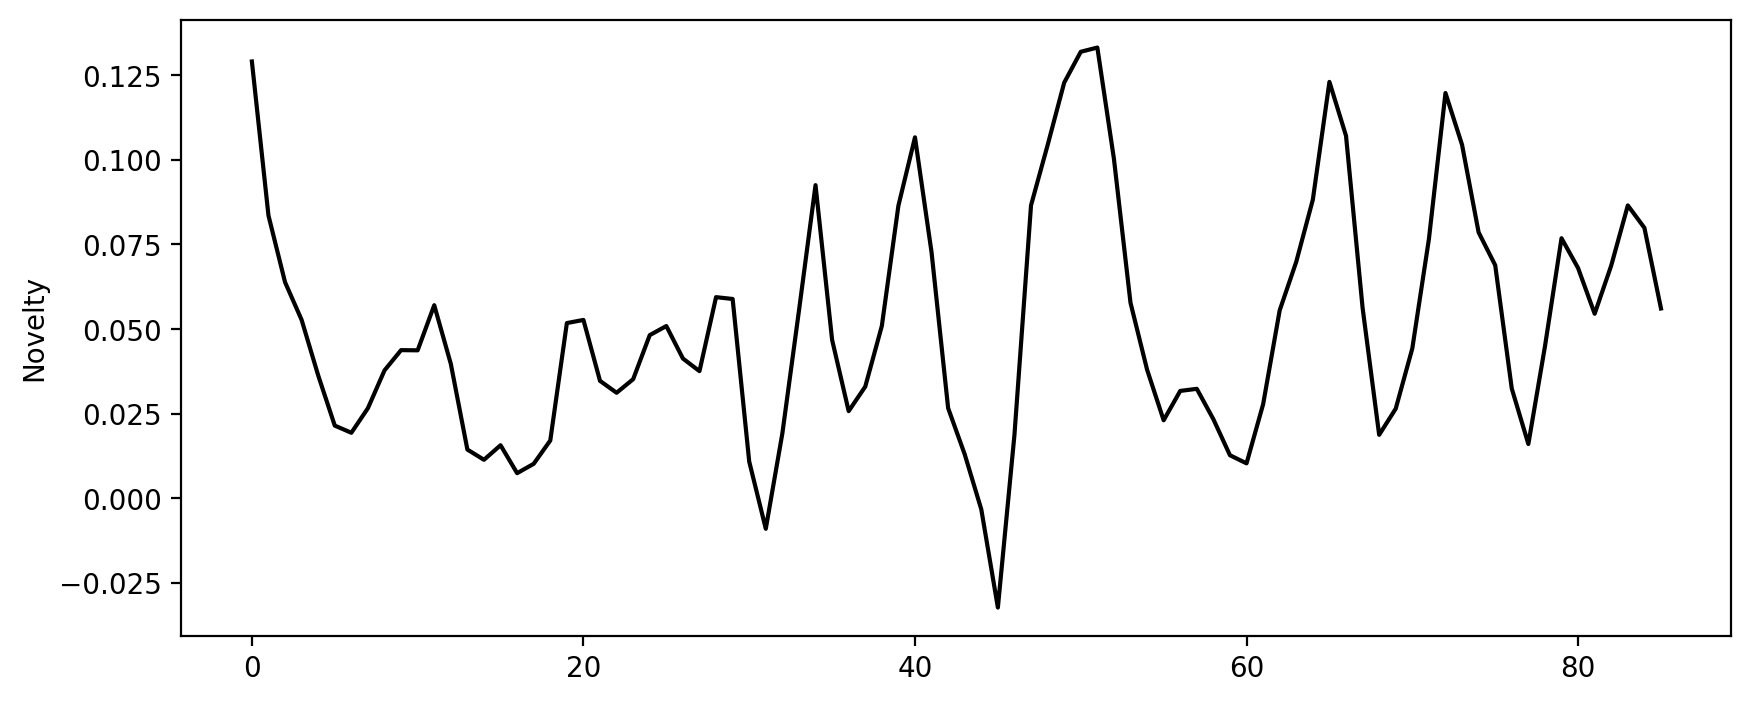

In [11]:

L_kernel = 10
nov = compute_novelty_ssm(self_sim_mat2, L=L_kernel, exclude=False)   

plt.figure(figsize=(10, 4))
plt.plot(nov, color='k')
plt.ylabel('Novelty')
plt.show() 

In [15]:
get_novelty_topk(nov, 10)

array([ 0, 40, 48, 49, 50, 51, 65, 66, 72, 73])